(2148, 1052, 3)


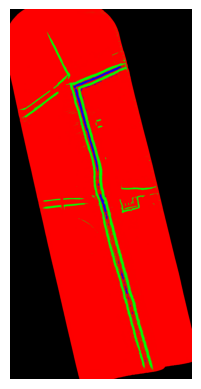

In [26]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

img_path = 'testing/Inference_dem_2/class_epoch_79.png'
img = cv2.imread(img_path)
img = img[:,:,::-1]

print(img.shape)
plt.imshow(img)
plt.axis('off')  # Hide the axis
plt.show()

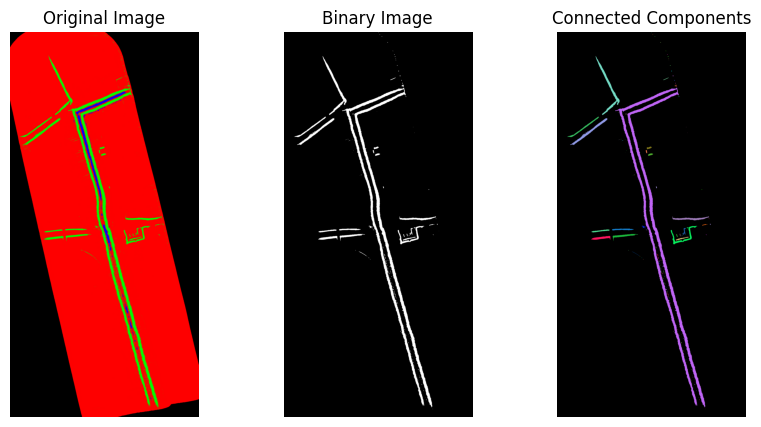

In [28]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Supongamos que 'img' ya está cargada y es una matriz numpy de 3 canales
# Extraer los canales de color
img_red = img[:, :, 0]
img_green = img[:, :, 1]
img_blue = img[:, :, 2]

# Crear una máscara binaria para detectar píxeles con color verde puro
# En este caso, asumimos que un píxel es verde puro si su canal verde es mayor que los canales rojo y azul
green_mask = np.logical_and(img_green > img_red, img_green > img_blue)
binary_img = green_mask.astype(np.uint8) * 255

# Realizar el análisis de conectividad de píxeles
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img, connectivity=8)

# Crear un mapa de colores para visualizar los componentes conectados
colored_labels = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
for i in range(1, num_labels):
    colored_labels[labels == i] = [np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256)]

# Display the original image, the binary image, and the colored labels
fig, axs = plt.subplots(1, 3, figsize=(10, 5))
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[0].axis('off')

axs[1].imshow(binary_img, cmap='gray')
axs[1].set_title('Binary Image')
axs[1].axis('off')

axs[2].imshow(colored_labels)
axs[2].set_title('Connected Components')
axs[2].axis('off')

plt.show()

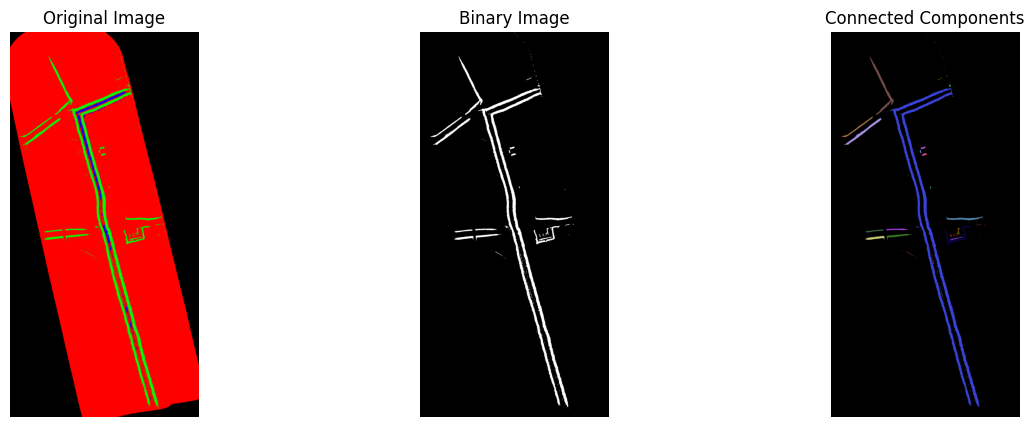

766

In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Supongamos que 'img' ya está cargada y es una matriz numpy de 3 canales
# Extraer los canales de color
img_red = img[:, :, 0]
img_green = img[:, :, 1]
img_blue = img[:, :, 2]

# Crear una máscara binaria para detectar píxeles con color verde puro
# En este caso, asumimos que un píxel es verde puro si su canal verde es mayor que los canales rojo y azul
green_mask = np.logical_and(img_green > img_red, img_green > img_blue)
binary_img = green_mask.astype(np.uint8) * 255

# Realizar el análisis de conectividad de píxeles
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img, connectivity=8)

# Crear un mapa de colores para visualizar los componentes conectados
colored_labels = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
for i in range(1, num_labels):
    colored_labels[labels == i] = [np.random.randint(0, 256), np.random.randint(0, 256), np.random.randint(0, 256)]

# Display the original image, the binary image, and the colored labels
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(img)
axs[0].set_title('Original Image')
axs[0].axis('off')
axs[1].imshow(binary_img, cmap='gray')
axs[1].set_title('Binary Image')
axs[1].axis('off')
axs[2].imshow(colored_labels)
axs[2].set_title('Connected Components')
axs[2].axis('off')
plt.show()


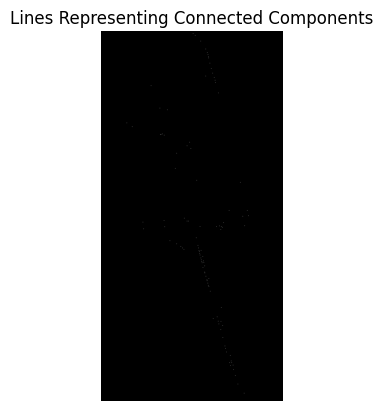

In [41]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Supongamos que 'img' ya está cargada y es una matriz numpy de 3 canales
# Extraer los canales de color
img_red = img[:, :, 0]
img_green = img[:, :, 1]
img_blue = img[:, :, 2]

# Crear una máscara binaria para detectar píxeles con color verde puro
# En este caso, asumimos que un píxel es verde puro si su canal verde es mayor que los canales rojo y azul
green_mask = np.logical_and(img_green > img_red, img_green > img_blue)
binary_img = green_mask.astype(np.uint8) * 255

# Realizar el análisis de conectividad de píxeles
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary_img, connectivity=8)

# Crear una imagen en blanco para dibujar las líneas
lines_img = np.zeros_like(img)

# Dibujar una línea en el centro de cada componente conectado
for i in range(1, num_labels):
    # Obtener los puntos del componente conectado
    component_mask = (labels == i).astype(np.uint8) * 255
    contours, _ = cv2.findContours(component_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Calcular el centroide del componente conectado
        M = cv2.moments(contours[0])
        if M["m00"] != 0:
            cX = int(M["m10"] / M["m00"])
            cY = int(M["m01"] / M["m00"])

            # Dibujar una línea desde el centroide hasta el borde del componente conectado
            cv2.line(lines_img, (cX, cY), (cX, cY), (255, 255, 255), 2)

# Mostrar la imagen con las líneas
plt.imshow(lines_img)
plt.title('Lines Representing Connected Components')
plt.axis('off')
plt.show()